## Human Activity Recognition System using Machine Learning techniques for Home Automation by Leon Vitanos

Dataset used: https://tev.fbk.eu/technologies/smartwatch-gestures-dataset

Eight different users performed twenty repetitions of twenty different gestures, for a total of 3200 sequences. Each sequence contains acceleration data from the 3-axis accelerometer of a first generation Sony SmartWatch™, as well as timestamps from the different clock sources available on an Android device. The smartwatch was worn on the user's right wrist. The gestures have been manually segmented by the users performing them by tapping the smartwatch screen at the beginning and at the end of every repetition.

<img src="https://i.imgur.com/U3Uqe9x.png">



In [16]:
import yaml
from utils import dotdict, make_range

with open('settings.yaml', 'r') as f:
    settings = dotdict(yaml.load(f, Loader=yaml.Loader))

### Load and preprocess dataset
We use the first 8 Haar transformation coefficients for each axis, creating a 24 vector for each sequence

In [17]:
from dataset import read_dataset

print("Loading and preprocessing dataset...")
dataset = read_dataset(settings.dataset)
print("In total", len(dataset.X_train) + len(dataset.X_test),
      "sequences have been loaded and preprocessed")

Loading and preprocessing dataset...


100%|██████████| 8/8 [00:03<00:00,  2.30it/s]

In total 3250 sequences have been loaded and preprocessed


### Split training (6 users) / test set (2 users)

## Find best algorithm
Between the following:
- K-nearest neighbors (KNN) 
- Decision Tree (DT)
- Random Forest (RF)
- Support Vector Machines (SVM)
- Multilayer perceptron (MLP)
- Convolutional neural network (CNN)
- Recurrent neural networks (RNN) using long-short term memory (LSTM)

### K-nearest neighbors (KNN)

100%|██████████| 99/99 [00:05<00:00, 16.51it/s]


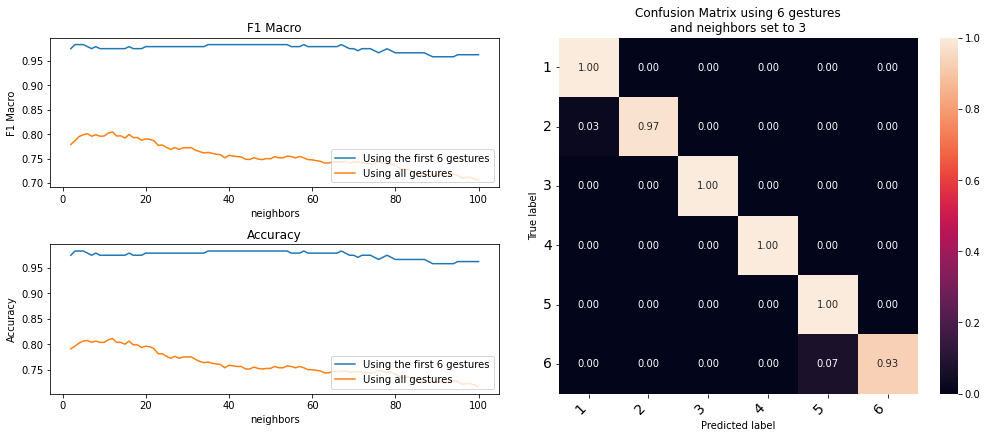

Max accuracy is 0.811, with F1 score 0.804, using all gestures and neighbors set to 12.
Max accuracy is 0.983, with F1 score 0.983, using 6 gestures and neighbors set to 3.

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from eval import SklearnEvaluator

best_accuracy, best_accuracy6 = [0] * 5, [0] * 5

gen_neighbors = lambda x: KNeighborsClassifier(n_neighbors=x,
                                               weights='distance')
evaluator = SklearnEvaluator(gen_neighbors, gen_neighbors, 'neighbors', 0,
                             dataset, best_accuracy, best_accuracy6)
evaluator.fit(make_range(**settings.knn.neighbors))

### Decision Tree (DT)

100%|██████████| 49/49 [00:01<00:00, 24.69it/s]


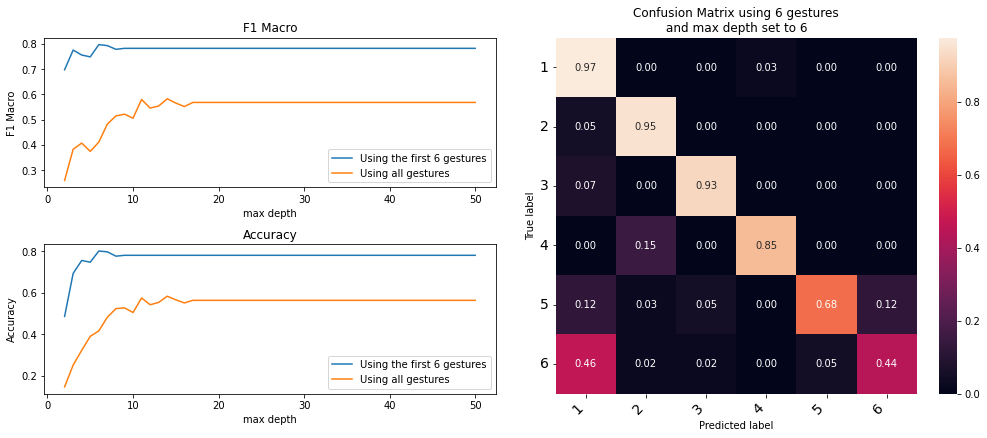

Max accuracy is 0.583, with F1 score 0.583, using all gestures and max depth set to 14.
Max accuracy is 0.801, with F1 score 0.797, using 6 gestures and max depth set to 6.

In [19]:
from sklearn.tree import DecisionTreeClassifier

gen_decision_tree = lambda x : DecisionTreeClassifier(max_depth=x, random_state=0)
evaluator = SklearnEvaluator(gen_decision_tree, gen_decision_tree, 'max depth',
                             1, dataset, best_accuracy, best_accuracy6)
evaluator.fit(make_range(**settings.decision_tree.depth))

### Random Forest (RF)

100%|██████████| 12/12 [00:40<00:00,  3.38s/it]


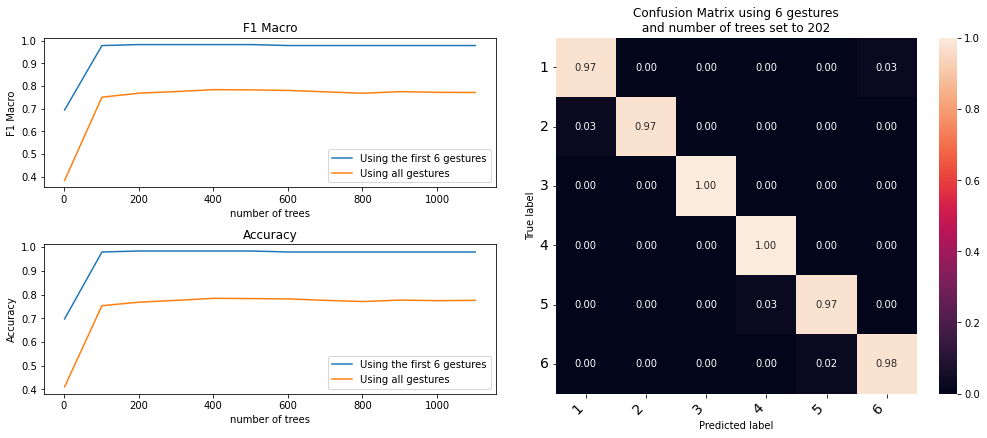

Max accuracy is 0.784, with F1 score 0.784, using all gestures and number of trees set to 402.
Max accuracy is 0.983, with F1 score 0.983, using 6 gestures and number of trees set to 202.

In [20]:
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

gen_random_forest = lambda x : RandomForestClassifier(n_estimators=x, random_state=0)
evaluator = SklearnEvaluator(gen_random_forest, gen_random_forest, 'number of trees',
                             2, dataset, best_accuracy, best_accuracy6)
evaluator.fit(make_range(**settings.random_forest.estimators))

### Support Vector Machines (SVM)

100%|██████████| 20/20 [00:02<00:00,  8.21it/s]


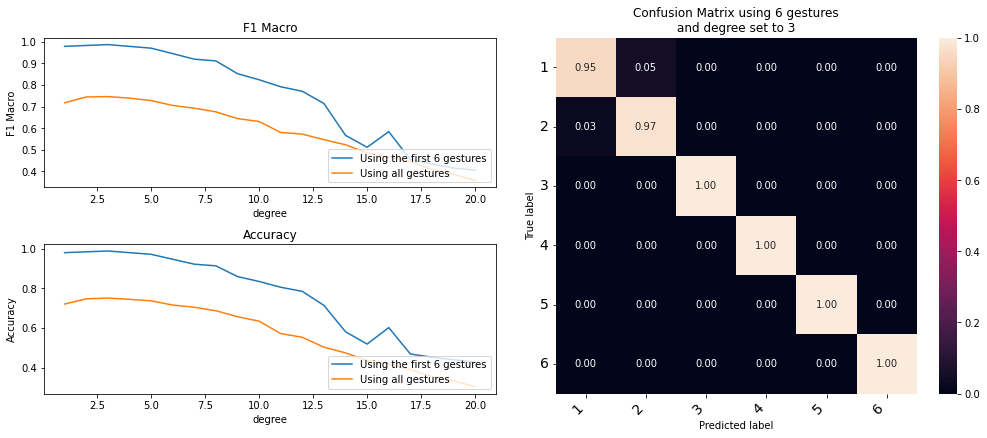

Max accuracy is 0.750, with F1 score 0.746, using all gestures and degree set to 3.
Max accuracy is 0.988, with F1 score 0.987, using 6 gestures and degree set to 3.

In [21]:
from sklearn.svm import SVC

gen_random_svm = lambda x: SVC(
    kernel='poly', gamma='scale', degree=x, random_state=0)
evaluator = SklearnEvaluator(gen_random_svm, gen_random_svm, 'degree', 3,
                             dataset, best_accuracy, best_accuracy6)
evaluator.fit(make_range(**settings.svm.degree))

## Deep Learning

### Multilayer perceptron (MLP)

### MLP Classifier using Sklearn

100%|██████████| 9/9 [00:38<00:00,  4.31s/it]


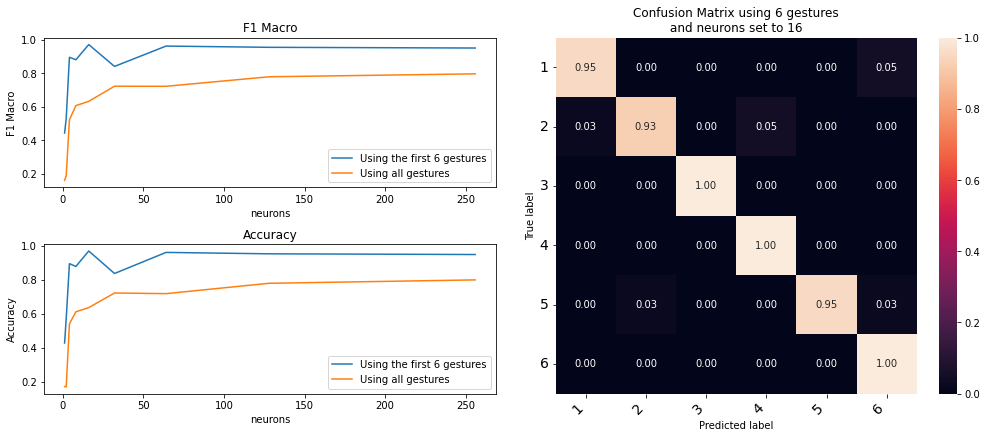

Max accuracy is 0.800, with F1 score 0.796, using all gestures and neurons set to 256.
Max accuracy is 0.971, with F1 score 0.971, using 6 gestures and neurons set to 16.

In [22]:
from sklearn.neural_network import MLPClassifier

gen_classifier = lambda x: MLPClassifier(
    hidden_layer_sizes=(x, x), random_state=settings.mlp.seed, max_iter=1000)
evaluator = SklearnEvaluator(gen_classifier, gen_classifier, 'neurons', 4,
                             dataset, best_accuracy, best_accuracy6)
evaluator.fit(make_range(**settings.mlp.neurons))

### Print accuracies for every algorithm

In [23]:
algorithms = ['KNN', 'DT', 'RF', 'SVM', 'MLP']

for algorithm, accuracy, accuracy6 in zip(algorithms, best_accuracy, best_accuracy6):
    accuracy = format(accuracy*100, '.2f')+'%'
    accuracy6 = format(accuracy6*100, '.2f')+'%'

    print('%-16s%-16s%s' % (algorithm, accuracy, accuracy6))

KNN             81.15%          98.34%
DT              58.30%          80.08%
RF              78.40%          98.34%
SVM             75.03%          98.76%
MLP             80.02%          97.10%


### Train the best model

In [26]:
# MLP for all the gestures
from sklearn import metrics
model = gen_classifier(256)
history = model.fit(dataset.X_train, dataset.y_train)
metrics.accuracy_score(dataset.y_test, model.predict(dataset.X_test))

0.8002496878901373